In [130]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation


In [22]:
from pmdarima.arima import auto_arima #SARIMAX using pmdarima
from skforecast.ForecasterSarimax import ForecasterSarimax

SARIMAX for Luzon

In [23]:
input_file = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/LUZ_Daily_Complete.csv'
data = pd.read_csv(input_file)
data = data.fillna(0)

X = data.values

y = data[['GWAP','LWAP']].values

In [24]:
train_size = int(0.6 * len(X))  # 60% for training
val_size = int(0.20 * len(X))   # 20% for validation
test_size = len(X) - train_size - val_size  # Remaining 15% for testing

train_data = X[:train_size]
train_labels = y[:train_size]

val_data = X[train_size:train_size + val_size]
val_labels = y[train_size:train_size + val_size]

test_data = X[train_size + val_size:]
test_labels = y[train_size + val_size:]
seq_len=7
batch_size=64

In [25]:
def classify_features(data):
    minmax_cols = []
    boxcox_cols = []
    yeojohnson_cols = []

    for i in range(data.shape[1]):  # Iterate over columns by index
        col_data = data[:, i]  # Get each column as a separate array
        skewness = skew(col_data)
        kurt = kurtosis(col_data)
        is_positive = np.all(col_data > 0)

        if -1 <= skewness <= 1 and -1 <= kurt <= 1:
            minmax_cols.append(i)  # Add index for MinMax family
        elif is_positive:
            boxcox_cols.append(i)  # Add index for BoxCox family
        else:
            yeojohnson_cols.append(i)  # Add index for YeoJohnson family

    return minmax_cols, boxcox_cols, yeojohnson_cols
minmax_cols, boxcox_cols, yeojohnson_cols = classify_features(X)

transformers = [
    ('minmax', MinMaxScaler(), minmax_cols),
    ('boxcox_minmax', Pipeline([
        ('boxcox', PowerTransformer(method='box-cox', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), boxcox_cols),
    ('yeojohnson_minmax', Pipeline([
        ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), yeojohnson_cols)
]


preprocessor = ColumnTransformer(transformers=transformers)

# Build the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


pipeline.fit(train_data)
transformed_train_data = pipeline.transform(train_data)
transformed_val_data = pipeline.transform(val_data)
transformed_test_data = pipeline.transform(test_data)

minmax_colsy, boxcox_colsy, yeojohnson_colsy = classify_features(y)
transformersy = [
    ('minmax', MinMaxScaler(), minmax_colsy),
    ('boxcox_minmax', Pipeline([
        ('boxcox', PowerTransformer(method='box-cox', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), boxcox_colsy),
    ('yeojohnson_minmax', Pipeline([
        ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('minmax', MinMaxScaler())
    ]), yeojohnson_colsy)
]
preprocessory = ColumnTransformer(transformers=transformersy)

# Build the full pipeline
pipeliney = Pipeline(steps=[
    ('preprocessor', preprocessory)
])
pipeliney.fit(train_labels)

transformed_train_labels = pipeliney.transform(train_labels)
transformed_val_labels = pipeliney.transform(val_labels)
transformed_test_labels = pipeliney.transform(test_labels)



In [26]:
date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])
train_date = date_df[:train_size]
val_date = date_df[train_size:train_size + val_size]
test_date= date_df[train_size + val_size:]

#Resetting the Index
val_date = val_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [27]:
#Converting to dataframes
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_val = pd.DataFrame(transformed_val_labels, columns = labels_columns)
labels_test = pd.DataFrame(transformed_test_labels, columns = labels_columns)

LUZ_data_columns = ['GWAP', 'LWAP', 'FLOW_LUZ','RESERVE_GWAP_Fr','RESERVE_GWAP_Ru','RESERVE_GWAP_Rd','RESERVE_GWAP_Dr','Hourly Demand','RAINFALL_Cubi Point','TMAX_Cubi Point','TMIN_Cubi Point','RAINFALL_NAIA','TMAX_NAIA','TMIN_NAIA','RAINFALL_Science Garden','TMAX_Science Garden','TMIN_Science Garden','RAINFALL_San Jose','TMAX_San Jose','TMIN_San Jose','RAINFALL_Tayabas','TMAX_Tayabas','TMIN_Tayabas','RAINFALL_CLSU','TMAX_CLSU','TMIN_CLSU','RAINFALL_Tanay','TMAX_Tanay','TMIN_Tanay','RAINFALL_Ambulong','TMAX_Ambulong','TMIN_Ambulong','RAINFALL_Casiguran','TMAX_Casiguran','TMIN_Casiguran','RAINFALL_Clark','TMAX_Clark','TMIN_Clark','RAINFALL_Calapan','TMAX_Calapan','TMIN_Calapan']
LUZ_data_train = pd.DataFrame(transformed_train_data, columns = LUZ_data_columns)
LUZ_data_val = pd.DataFrame(transformed_val_data, columns = LUZ_data_columns)
LUZ_data_test = pd.DataFrame(transformed_test_data, columns = LUZ_data_columns)


In [85]:
#Preparing GWAP datasets
LUZ_GWAP_train = labels_train['GWAP']
LUZ_GWAP_train = pd.concat([train_date,LUZ_GWAP_train], axis=1)
LUZ_GWAP_train.set_index('Date', inplace=True)
LUZ_GWAP_train.index = pd.to_datetime(LUZ_GWAP_train.index)
LUZ_GWAP_train.index.freq='D'
LUZ_GWAP_train = LUZ_GWAP_train.squeeze()


LUZ_GWAP_val = labels_val['GWAP']
LUZ_GWAP_val = pd.concat([val_date,LUZ_GWAP_val], axis=1)
LUZ_GWAP_val.set_index('Date', inplace=True)
LUZ_GWAP_val.index = pd.to_datetime(LUZ_GWAP_val.index)
LUZ_GWAP_val.index.freq='D'
LUZ_GWAP_val = LUZ_GWAP_val.squeeze()

LUZ_GWAP_test = labels_test['GWAP']
LUZ_GWAP_test = pd.concat([test_date,LUZ_GWAP_test], axis=1)
LUZ_GWAP_test.set_index('Date', inplace=True)
LUZ_GWAP_test.index = pd.to_datetime(LUZ_GWAP_test.index)
LUZ_GWAP_test.index.freq='D'
LUZ_GWAP_test = LUZ_GWAP_test.squeeze()

LUZ_GWAP = pd.concat([LUZ_GWAP_train, LUZ_GWAP_val, LUZ_GWAP_test], ignore_index=False)


#Preparing the LWAP datasets
LUZ_LWAP_train = labels_train['LWAP']
LUZ_LWAP_train = pd.concat([train_date,LUZ_LWAP_train], axis=1)
LUZ_LWAP_train.set_index('Date', inplace=True)
LUZ_LWAP_train.index = pd.to_datetime(LUZ_LWAP_train.index)
LUZ_LWAP_train.index.freq='D'
LUZ_LWAP_train = LUZ_LWAP_train.squeeze()

LUZ_LWAP_val = labels_val['LWAP']
LUZ_LWAP_val = pd.concat([val_date,LUZ_LWAP_val], axis=1)
LUZ_LWAP_val.set_index('Date', inplace=True)
LUZ_LWAP_val.index = pd.to_datetime(LUZ_LWAP_val.index)
LUZ_LWAP_val.index.freq='D'
LUZ_LWAP_val = LUZ_LWAP_val.squeeze()

LUZ_LWAP_test = labels_test['LWAP']
LUZ_LWAP_test = pd.concat([test_date,LUZ_LWAP_test], axis=1)
LUZ_LWAP_test.set_index('Date', inplace=True)
LUZ_LWAP_test.index = pd.to_datetime(LUZ_LWAP_test.index)
LUZ_LWAP_test.index.freq='D'
LUZ_LWAP_test = LUZ_LWAP_test.squeeze()

#Preparing the exogenous datasets
LUZ_exog_train = LUZ_data_train[['FLOW_LUZ','RESERVE_GWAP_Fr','RESERVE_GWAP_Ru','RESERVE_GWAP_Rd','RESERVE_GWAP_Dr','Hourly Demand','RAINFALL_Cubi Point','TMAX_Cubi Point','TMIN_Cubi Point','RAINFALL_NAIA','TMAX_NAIA','TMIN_NAIA','RAINFALL_Science Garden','TMAX_Science Garden','TMIN_Science Garden','RAINFALL_San Jose','TMAX_San Jose','TMIN_San Jose','RAINFALL_Tayabas','TMAX_Tayabas','TMIN_Tayabas','RAINFALL_CLSU','TMAX_CLSU','TMIN_CLSU','RAINFALL_Tanay','TMAX_Tanay','TMIN_Tanay','RAINFALL_Ambulong','TMAX_Ambulong','TMIN_Ambulong','RAINFALL_Casiguran','TMAX_Casiguran','TMIN_Casiguran','RAINFALL_Clark','TMAX_Clark','TMIN_Clark','RAINFALL_Calapan','TMAX_Calapan','TMIN_Calapan']]
LUZ_exog_train = pd.concat([train_date,LUZ_exog_train], axis=1)
LUZ_exog_train.set_index('Date', inplace=True)

LUZ_exog_val = LUZ_data_val[['FLOW_LUZ','RESERVE_GWAP_Fr','RESERVE_GWAP_Ru','RESERVE_GWAP_Rd','RESERVE_GWAP_Dr','Hourly Demand','RAINFALL_Cubi Point','TMAX_Cubi Point','TMIN_Cubi Point','RAINFALL_NAIA','TMAX_NAIA','TMIN_NAIA','RAINFALL_Science Garden','TMAX_Science Garden','TMIN_Science Garden','RAINFALL_San Jose','TMAX_San Jose','TMIN_San Jose','RAINFALL_Tayabas','TMAX_Tayabas','TMIN_Tayabas','RAINFALL_CLSU','TMAX_CLSU','TMIN_CLSU','RAINFALL_Tanay','TMAX_Tanay','TMIN_Tanay','RAINFALL_Ambulong','TMAX_Ambulong','TMIN_Ambulong','RAINFALL_Casiguran','TMAX_Casiguran','TMIN_Casiguran','RAINFALL_Clark','TMAX_Clark','TMIN_Clark','RAINFALL_Calapan','TMAX_Calapan','TMIN_Calapan']]
LUZ_exog_val = pd.concat([val_date,LUZ_exog_val], axis=1)
LUZ_exog_val.set_index('Date', inplace=True)

LUZ_exog_test = LUZ_data_test[['FLOW_LUZ','RESERVE_GWAP_Fr','RESERVE_GWAP_Ru','RESERVE_GWAP_Rd','RESERVE_GWAP_Dr','Hourly Demand','RAINFALL_Cubi Point','TMAX_Cubi Point','TMIN_Cubi Point','RAINFALL_NAIA','TMAX_NAIA','TMIN_NAIA','RAINFALL_Science Garden','TMAX_Science Garden','TMIN_Science Garden','RAINFALL_San Jose','TMAX_San Jose','TMIN_San Jose','RAINFALL_Tayabas','TMAX_Tayabas','TMIN_Tayabas','RAINFALL_CLSU','TMAX_CLSU','TMIN_CLSU','RAINFALL_Tanay','TMAX_Tanay','TMIN_Tanay','RAINFALL_Ambulong','TMAX_Ambulong','TMIN_Ambulong','RAINFALL_Casiguran','TMAX_Casiguran','TMIN_Casiguran','RAINFALL_Clark','TMAX_Clark','TMIN_Clark','RAINFALL_Calapan','TMAX_Calapan','TMIN_Calapan']]
LUZ_exog_test = pd.concat([test_date,LUZ_exog_test], axis=1)
LUZ_exog_test.set_index('Date', inplace=True)


In [29]:
#Plotting Train LWAP ang GWAP
# Create the line plot
luz_gwap_plot = px.line(LUZ_GWAP_train, x=LUZ_GWAP_train.index, y='GWAP')
luz_lwap_plot = px.line(LUZ_LWAP_train, x=LUZ_LWAP_train.index, y='LWAP')
# Set the title using the ticker value
luz_gwap_plot.update_layout(title=f"Luzon GWAP")
luz_lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
luz_gwap_plot.show()
luz_lwap_plot.show()

In [30]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [31]:
#Checking for stationarity in GWAP data
perform_differencing(LUZ_GWAP_train)
perform_differencing(LUZ_LWAP_train)

LUZ_diff_exog = perform_df_differencing(LUZ_exog_train)
LUZ_diff_exog = LUZ_diff_exog.fillna(0)


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value retur

Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.
Column 'FLOW_LUZ' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'RAINFALL_Cubi Point' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 1 times.
Column 'TMIN_Cubi Point' is stationary after differencing 1 times.
Column 'RAINFALL_NAIA' is stationary after differencing 1 times.
Column 'TMAX_NAIA' is stationary after differencing 1 times.
Column 'TMIN_NAIA' is stationary after differencing 2 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 1 times.
Column 'TMAX_Science Garden' is stationary aft

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_71835/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value retu

In [32]:
print(LUZ_diff_exog)

            FLOW_LUZ  RESERVE_GWAP_Fr  RESERVE_GWAP_Ru  RESERVE_GWAP_Rd  \
Date                                                                      
2022-01-01  0.000000         0.000000         0.000000         0.000000   
2022-01-02  0.063063        -0.063063        -0.135802        -0.020202   
2022-01-03  0.036036         0.126126         0.135802         0.080808   
2022-01-04  0.036036         0.036036        -0.037037         0.000000   
2022-01-05  0.018018         0.027027         0.123457         0.040404   
...              ...              ...              ...              ...   
2023-03-10 -0.036036        -0.054054        -0.222222        -0.191919   
2023-03-11  0.117117        -0.063063        -0.024691         0.151515   
2023-03-12 -0.009009         0.126126         0.234568         0.090909   
2023-03-13 -0.198198        -0.207207        -0.135802        -0.282828   
2023-03-14  0.261261         0.180180         0.135802         0.252525   

            RESERVE_GWAP

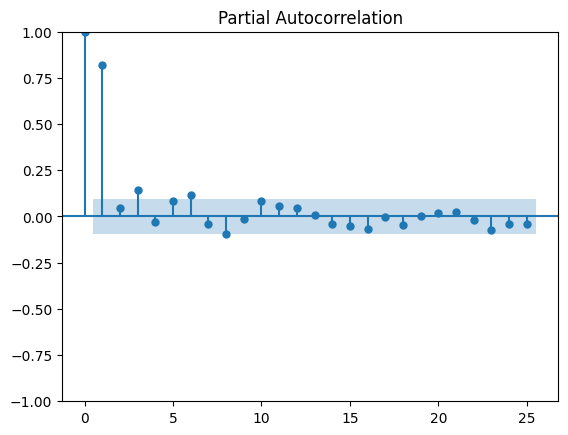

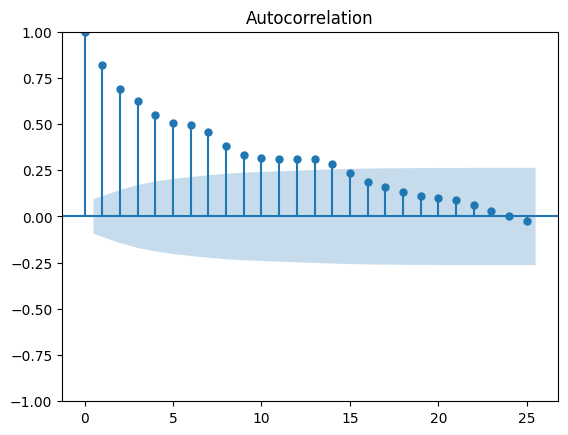

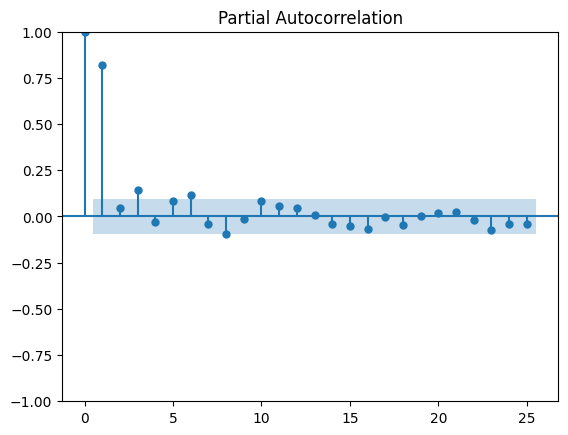

In [33]:
# Visualize autocorrelation using plot_acf
plot_acf(LUZ_GWAP_train['GWAP'], lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LUZ_GWAP_train['GWAP'], lags=25, alpha=0.05)

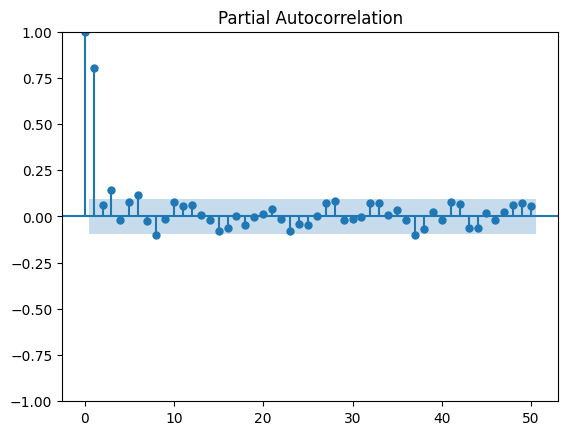

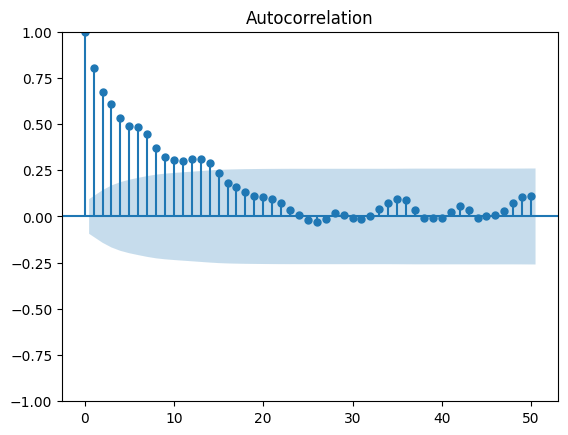

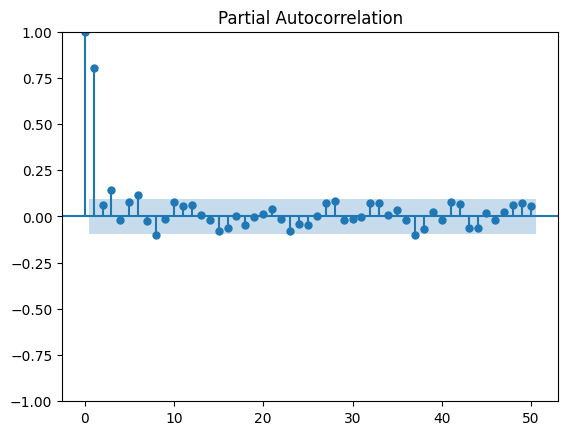

In [34]:
# Visualize autocorrelation using plot_acf
plot_acf(LUZ_LWAP_train['LWAP'], lags=50, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LUZ_LWAP_train['LWAP'], lags=50, alpha=0.05)

In [165]:
model102 = SARIMAX(endog = LUZ_GWAP_train, exog=LUZ_diff_exog, order=(1, 0, 2), seasonal_order=(0, 0, 0, 0),enforce_invertibility='TRUE', enforce_stationarity='TRUE', freq='D', missing='drop')
results = model102.fit(method='lbfgs', maxiter=300)
results.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           43     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05886D+01    |proj g|=  6.93147D+04


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   43      2     54      2     0     0   5.909D+04  -1.099D+01
  F =  -10.990597570334456     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   GWAP   No. Observations:                  438
Model:               SARIMAX(1, 0, 2)   Log Likelihood                4813.882
Date:                Sat, 26 Oct 2024   AIC                          -9541.763
Time:                        20:49:18   BIC                          -9366.228
Sample:                    01-01-2022   HQIC                         -9472.502
                         - 03-14-2023                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_LUZ                -4.119e-07   9.88e-07     -0.417      0.677   -2.35e-06    1.52e-06
RESERVE_GWAP_Fr         -5.488e-07   1.04e-06     -0.529      0.597   -2.58e-06    1.48e-06
RESERVE_GWAP_Ru         -5.186e-07   9.91e-07     -0.523      0.601   -2.46e-06    1.42e-06
RESERVE_GWAP_Rd           -7.5e-07   1.01e-06     -0.742      0.458   -2.73e-06    1.23e-06
RESERVE_GWAP_Dr         -5.465e-07   7.64e-07     -0.716      0.474   -2.04e-06     9.5e-07
Hourly Demand           -2.725e-07   1.19e-06     -0.229      0.819   -2.61e-06    2.06e-06
RAINFALL_Cubi Point     -5.018e-07      1e-06     -0.501      0.616   -2.46e-06    1.46e-06
TMAX_Cubi Point         -8.591e-07   5.96e-07     -1.442      0.149   -2.03e-06    3.09e-07
TMIN_Cubi Point         -3.661e-07   1.07e-06     -0.344      0.731   -2.45e-06    1.72e-06
RAINFALL_NAIA           -4.919e-07   9.66e-07     -0.509      0.611   -2.39e-06     1.4e-06
TMAX_NAIA                -7.16e-07   9.25e-07     -0.774      0.439   -2.53e-06     1.1e-06
TMIN_NAIA               -1.964e-06   4.33e-07     -4.532      0.000   -2.81e-06   -1.11e-06
RAINFALL_Science Garden -3.903e-07   1.04e-06     -0.374      0.709   -2.44e-06    1.66e-06
TMAX_Science Garden     -3.126e-07   1.39e-06     -0.225      0.822   -3.04e-06    2.41e-06
TMIN_Science Garden     -4.465e-07   1.01e-06     -0.444      0.657   -2.42e-06    1.52e-06
RAINFALL_San Jose       -5.042e-07    9.3e-07     -0.542      0.588   -2.33e-06    1.32e-06
TMAX_San Jose           -4.108e-07   9.33e-07     -0.440      0.660   -2.24e-06    1.42e-06
TMIN_San Jose               1.0000    1.8e-05   5.56e+04      0.000       1.000       1.000
RAINFALL_Tayabas        -1.066e-07   1.77e-05     -0.006      0.995   -3.47e-05    3.45e-05
TMAX_Tayabas            -6.339e-07   8.15e-07     -0.778      0.437   -2.23e-06    9.63e-07
TMIN_Tayabas            -4.837e-07   1.09e-06     -0.444      0.657   -2.62e-06    1.65e-06
RAINFALL_CLSU           -6.412e-07   7.93e-07     -0.809      0.419   -2.19e-06    9.12e-07
TMAX_CLSU               -3.382e-07   1.43e-06     -0.236      0.813   -3.14e-06    2.47e-06
TMIN_CLSU               -1.884e-07   1.77e-06     -0.107      0.915   -3.65e-06    3.28e-06
RAINFALL_Tanay           -9.75e-08   2.45e-06     -0.040      0.968   -4.89e-06     4.7e-06
TMAX_Tanay              -5.653e-07    8.2e-07     -0.689      0.491   -2.17e-06    1.04e-06
TMIN_Tanay              -1.456e-06   4.21e-07     -3.454      0.001   -2.28e-06    -6.3e-07
RAINFALL_Ambulong       -4.651e-08   2.57e-06     -0.018      0.986   -5.09e-06    4.99e-06
TMAX_Ambulong           -2.909e-06   3.55e-07     -8.195      0.000    -3.6e-06   -2.21e-06
TMIN_Ambulong           -1.927e-06   4.35e-07     -4.425      0.000   -2.78e-06   -1.07e-06
RAINFALL_Casiguran      -2.296e-06   4.08e-07     -5.622      0.000    -3.1e-06    -1.5e-06
TMAX_Casiguran          -1.897e-06   3.59e-07     -5.288      0.000    -2.6e-06   -1.19e-06
TMIN_Casiguran       

In [164]:
model111 = SARIMAX(endog = LUZ_GWAP_train, exog=LUZ_diff_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),enforce_invertibility='TRUE', enforce_stationarity='TRUE', freq='D', missing='drop')
results111 = model111.fit(method='lbfgs', maxiter=300)
results111.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           42     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.87863D+00    |proj g|=  4.65266D+06


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   42      1     21      1     0     0   4.653D+06  -9.879D+00
  F =  -9.8786289657230562     

ABNORMAL_TERMINATION_IN_LNSRCH                              


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   GWAP   No. Observations:                  438
Model:               SARIMAX(1, 1, 1)   Log Likelihood                4326.839
Date:                Sat, 26 Oct 2024   AIC                          -8569.679
Time:                        20:44:00   BIC                          -8398.322
Sample:                    01-01-2022   HQIC                         -8502.060
                         - 03-14-2023                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_LUZ                 7.401e-17   6.46e-12   1.15e-05      1.000   -1.27e-11    1.27e-11
RESERVE_GWAP_Fr         -2.775e-16   2.99e-11  -9.29e-06      1.000   -5.86e-11    5.86e-11
RESERVE_GWAP_Ru          1.071e-16   3.34e-11    3.2e-06      1.000   -6.55e-11    6.55e-11
RESERVE_GWAP_Rd          1.004e-16   1.94e-11   5.17e-06      1.000   -3.81e-11    3.81e-11
RESERVE_GWAP_Dr         -1.677e-16   3.53e-11  -4.75e-06      1.000   -6.91e-11    6.91e-11
Hourly Demand            1.248e-16   5.66e-11   2.21e-06      1.000   -1.11e-10    1.11e-10
RAINFALL_Cubi Point      2.288e-16    4.4e-11   5.19e-06      1.000   -8.63e-11    8.63e-11
TMAX_Cubi Point         -5.268e-17   5.17e-11  -1.02e-06      1.000   -1.01e-10    1.01e-10
TMIN_Cubi Point          1.188e-16   7.98e-12   1.49e-05      1.000   -1.56e-11    1.56e-11
RAINFALL_NAIA           -4.418e-17   6.43e-12  -6.88e-06      1.000   -1.26e-11    1.26e-11
TMAX_NAIA               -1.416e-16   5.25e-11  -2.69e-06      1.000   -1.03e-10    1.03e-10
TMIN_NAIA                 8.68e-17   4.53e-11   1.91e-06      1.000   -8.89e-11    8.89e-11
RAINFALL_Science Garden  2.051e-16   1.51e-11   1.36e-05      1.000   -2.97e-11    2.97e-11
TMAX_Science Garden      1.876e-17   4.03e-12   4.66e-06      1.000   -7.89e-12    7.89e-12
TMIN_Science Garden      -3.53e-16    2.3e-11  -1.54e-05      1.000    -4.5e-11     4.5e-11
RAINFALL_San Jose       -2.658e-16   1.65e-11  -1.61e-05      1.000   -3.24e-11    3.24e-11
TMAX_San Jose            1.601e-16   5.89e-11   2.72e-06      1.000   -1.15e-10    1.15e-10
TMIN_San Jose               1.0000   4.27e-11   2.34e+10      0.000       1.000       1.000
RAINFALL_Tayabas         1.473e-15    4.2e-11    3.5e-05      1.000   -8.23e-11    8.24e-11
TMAX_Tayabas            -4.978e-16   2.79e-11  -1.79e-05      1.000   -5.46e-11    5.46e-11
TMIN_Tayabas             2.752e-16   9.31e-12   2.96e-05      1.000   -1.82e-11    1.82e-11
RAINFALL_CLSU             1.26e-16   1.39e-11   9.06e-06      1.000   -2.73e-11    2.73e-11
TMAX_CLSU                1.811e-16   3.42e-11    5.3e-06      1.000    -6.7e-11     6.7e-11
TMIN_CLSU               -8.219e-16   9.01e-12  -9.12e-05      1.000   -1.77e-11    1.77e-11
RAINFALL_Tanay           5.106e-17   2.26e-11   2.26e-06      1.000   -4.43e-11    4.43e-11
TMAX_Tanay               1.897e-16   1.87e-11   1.01e-05      1.000   -3.67e-11    3.67e-11
TMIN_Tanay               1.391e-16   1.22e-13      0.001      0.999    -2.4e-13     2.4e-13
RAINFALL_Ambulong        7.793e-16   1.25e-17     62.294      0.000    7.55e-16    8.04e-16
TMAX_Ambulong            8.897e-17   4.34e-13      0.000      1.000   -8.51e-13    8.52e-13
TMIN_Ambulong            1.777e-16   9.93e-13      0.000      1.000   -1.95e-12    1.95e-12
RAINFALL_Casiguran       1.389e-17   1.21e-10   1.14e-07      1.000   -2.38e-10    2.38e-10
TMAX_Casiguran          -1.533e-16   1.65e-12  -9.32e-05      1.000   -3.23e-12    3.23e-12
TMIN_Casiguran       

In [101]:
#Auto-Arima: Identification of best orders using AIC
LUZ_GWAP_sarimax_diff = auto_arima(LUZ_GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=2, max_d=2, max_q=14, 
                            seasonal=False,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=True,
                            exog=LUZ_diff_exog)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-763.878, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-770.076, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-775.201, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-765.870, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-796.109, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-794.692, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-793.821, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-792.436, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-786.175, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-792.034, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-798.093, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-777.193, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-772.068, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-796.685, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [102]:
LUZ_GWAP_sarimax = auto_arima(LUZ_GWAP_train, 
                            start_p=0, d=0, start_q=0,
                            seasonal=False,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=True,
                            random_state=20, n_fits=50,
                            exogenous=LUZ_diff_exog)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=840.319, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-765.368, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=328.373, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-775.640, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-761.457, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-792.020, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3.855, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-791.112, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-790.329, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-165.737, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-788.292, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-807.730, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-679.080, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-

In [162]:
forecaster111 = ForecasterSarimax(LUZ_GWAP_sarimax_diff)
metric, predictions111 = backtesting_sarimax(
                          forecaster            = forecaster111,
                          y                     = LUZ_GWAP,
                          initial_train_size    = len(LUZ_GWAP_train),
                          fixed_train_size      = True,
                          steps=293,
                          metric                = 'mean_absolute_error',
                          refit                 = False,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )
display(metric)
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 438
Number of observations used for backtesting: 292
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 293
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 292 observations.

Fold: 0
    Training:   2022-01-01 00:00:00 -- 2023-03-14 00:00:00  (n=438)
    Validation: 2023-03-15 00:00:00 -- 2023-12-31 00:00:00  (n=292)



100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


,mean_absolute_error
0,0.136877


,pred
2023-03-15,0.484258
2023-03-16,0.478540
2023-03-17,0.489471
2023-03-18,0.513321


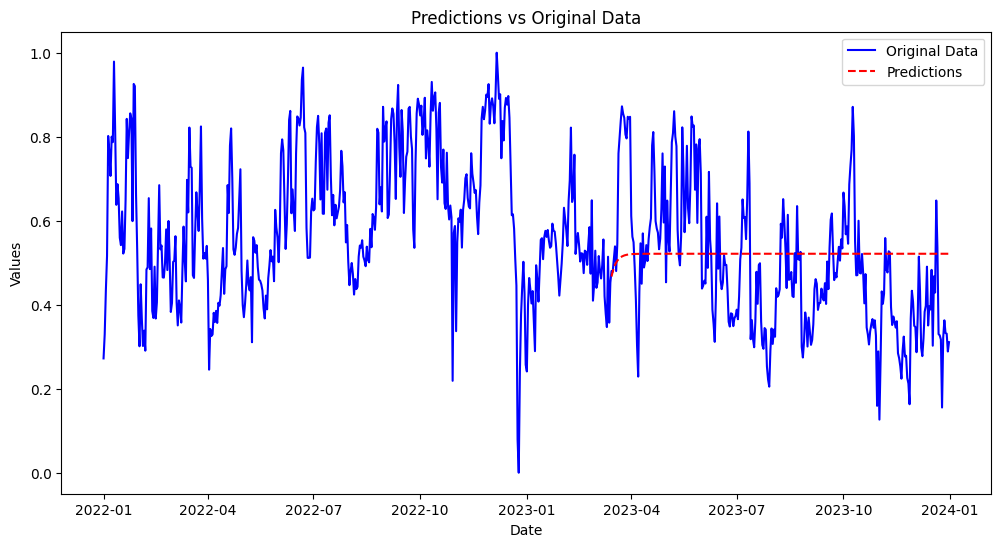

In [163]:
plt.figure(figsize=(12, 6))
plt.plot(LUZ_GWAP, label='Original Data', color='blue')
plt.plot(predictions111, label='Predictions', color='red', linestyle='--')
plt.title('Predictions vs Original Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [153]:
forecaster102 = ForecasterSarimax(LUZ_GWAP_sarimax)
metric102, predictions102 = backtesting_sarimax(
                          forecaster            = forecaster102,
                          y                     = LUZ_GWAP,
                          initial_train_size    = len(LUZ_GWAP_train),
                          fixed_train_size      = True,
                          steps=292,
                          metric                = 'mean_absolute_error',
                          refit                 = False,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )
display(metric102)
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 438
Number of observations used for backtesting: 292
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 292
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2022-01-01 00:00:00 -- 2023-03-14 00:00:00  (n=438)
    Validation: 2023-03-15 00:00:00 -- 2023-12-31 00:00:00  (n=292)



100%|██████████| 1/1 [00:00<00:00, 79.54it/s]


,mean_absolute_error
0,0.168742


,pred
2023-03-15,0.484258
2023-03-16,0.478540
2023-03-17,0.489471
2023-03-18,0.513321


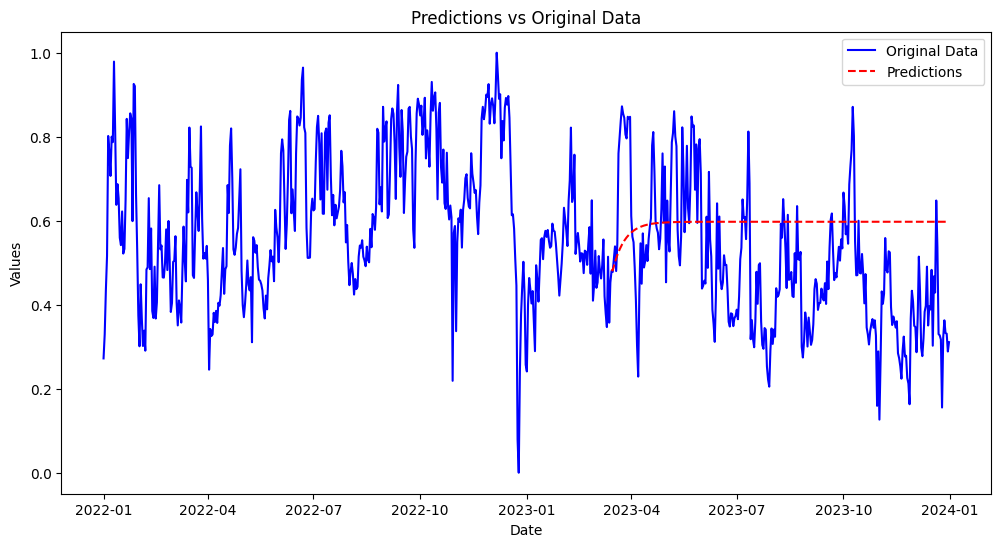

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(LUZ_GWAP, label='Original Data', color='blue')
plt.plot(predictions102, label='Predictions', color='red', linestyle='--')
plt.title('Predictions vs Original Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [157]:
def fit_sarimax(data, model, data_test):
    
    # ARIMA model with ForecasterSarimax and skforecast Sarimax
    # ==============================================================================
    forecaster = ForecasterSarimax(regressor=model)
    forecaster.fit(y=data, suppress_warnings=True)

    # Prediction
    predictions = forecaster.predict(steps=len(data_test))
    
    # Calculate MSE
    mae = mean_absolute_error(data_test, predictions)
    print(f"Mean Absolute Error (MAE): {mae}")

    
    # Plot predictions
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 3))
    data.plot(ax=ax, label='train')
    data_test.plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='Predictions')
    ax.set_title('Predictions with ARIMA models')
    ax.legend()

    return predictions, mae


Mean Absolute Error (MAE): 0.16874224266548146


(2023-03-15    0.484258
 2023-03-16    0.481660
 2023-03-17    0.492089
 2023-03-18    0.501580
 2023-03-19    0.510216
                 ...   
 2023-12-27    0.597528
 2023-12-28    0.597528
 2023-12-29    0.597528
 2023-12-30    0.597528
 2023-12-31    0.597528
 Freq: D, Name: pred, Length: 292, dtype: float64,
 0.16874224266548146)

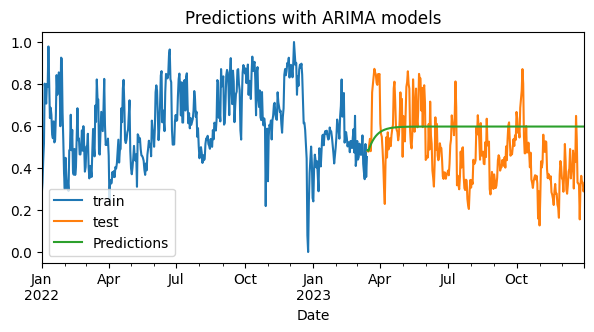

In [152]:
fit_sarimax(LUZ_GWAP_train,LUZ_GWAP_sarimax,LUZ_GWAP_test2)

Mean Absolute Error (MAE): 0.13687666407476454


(2023-03-15    0.467035
 2023-03-16    0.478495
 2023-03-17    0.487537
 2023-03-18    0.494672
 2023-03-19    0.500301
                 ...   
 2023-12-27    0.521353
 2023-12-28    0.521353
 2023-12-29    0.521353
 2023-12-30    0.521353
 2023-12-31    0.521353
 Freq: D, Name: pred, Length: 292, dtype: float64,
 0.13687666407476454)

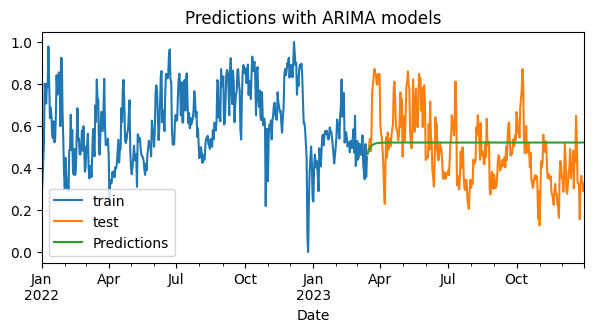

In [161]:
fit_sarimax(LUZ_GWAP_train,LUZ_GWAP_sarimax_diff,LUZ_GWAP_test2)

In [166]:
#experiment 2
def fit_sarimax2(data_train, model, data_test):
    # Initialize the SARIMAX forecaster
    forecaster = ForecasterSarimax(regressor=model)
    
    # Fit the forecaster to the training data
    forecaster.fit(y=data_train, suppress_warnings=True)

    # Prediction on the training set
    predictions_train = forecaster.forecast(steps=len(data_train))
    
    # Calculate MAE for the training set
    mae_train = mean_absolute_error(data_train, predictions_train)
    print(f"Mean Absolute Error (MAE) on Training Set: {mae_train}")

    # Prediction on the test set
    predictions_test = forecaster.forecast(steps=len(data_test))
    
    # Calculate MAE for the test set
    mae_test = mean_absolute_error(data_test, predictions_test)
    print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

    # Plot predictions
    fig, ax = plt.subplots(figsize=(10, 5))
    data_train.plot(ax=ax, label='Training Data')
    data_test.plot(ax=ax, label='Test Data')
    predictions_train.plot(ax=ax, label='Predictions on Training Set')
    predictions_test.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
    ax.set_title('SARIMAX Predictions')
    ax.legend()
    plt.show()

    return predictions_train, mae_train, predictions_test, mae_test

In [167]:
fit_sarimax2(LUZ_GWAP_train,LUZ_GWAP_sarimax,LUZ_GWAP_train)

AttributeError: 'ForecasterSarimax' object has no attribute 'forecast'

In [150]:
LUZ_GWAP_test2 = pd.concat([LUZ_GWAP_val, LUZ_GWAP_test], ignore_index=False)
print(LUZ_GWAP_test2)


Date
2023-03-15    0.480256
2023-03-16    0.477933
2023-03-17    0.507448
2023-03-18    0.538917
2023-03-19    0.480170
                ...   
2023-12-27    0.362859
2023-12-28    0.332509
2023-12-29    0.331029
2023-12-30    0.288643
2023-12-31    0.310847
Freq: D, Name: GWAP, Length: 292, dtype: float64
